In [1]:
# primary settings
state = 'LA'
district_type = 'SH'
level = 'vtd'
deviation = 0.10  # 0.10 means 10% means +/-5%
minority = 'Black'

In [2]:
filepath = 'C:\\districting-data-2020-reprojection\\'
filename = state + '_' + level + '.json'

from read import read_graph_from_json
G = read_graph_from_json( filepath + filename )
print("number of nodes, edges:",G.number_of_nodes(),G.number_of_edges())

number of nodes, edges: 3540 9889


In [3]:
from number_of_districts import number_of_districts

G._k = number_of_districts[state, district_type]
ideal_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes ) / G._k

import math
G._L = math.ceil(  ideal_population * (1-deviation/2) )
G._U = math.floor( ideal_population * (1+deviation/2) )

print("Using k, L, U =",G._k,G._L,G._U)

Using k, L, U = 105 42142 46577


In [4]:
# Phase 1: carve Gingles districts
from carve import carving_heuristic
gingles_districts = carving_heuristic(G, minority)
print(f"Finished carving off {len(gingles_districts)} Gingles districts.")

Seeking districts that split <= 0 counties.
Seeking districts that split <= 1 counties.
Allowing to split: ['22107']
Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-16
District 1 with Black VAP 56.72% and Polsby-Popper score 0.42
Allowing to split: ['22023']
Allowing to split: ['22035']
Allowing to split: ['22081']
Allowing to split: ['22025']
Allowing to split: ['22021']
Allowing to split: ['22123']
Allowing to split: ['22065']
Allowing to split: ['22091']
Allowing to split: ['22013']
Allowing to split: ['22127']
Allowing to split: ['22027']
Allowing to split: ['22059']
Allowing to split: ['22049']
Allowing to split: ['22125']
Allowing to split: ['22029']
Allowing to split: ['22037']
Allowing to split: ['22041']
Allowing to split: ['22083']
Allowing to split: ['22093']
Allowing to split: ['22077']
Allowing to split: ['22007']
Allowing to split: ['22111']
Allowing to split: ['22085']
Allowing to split: ['22043']
Allowing to split: ['22003']
Allow

Exporting to csv...
Exporting to png...
0.39179283935837644


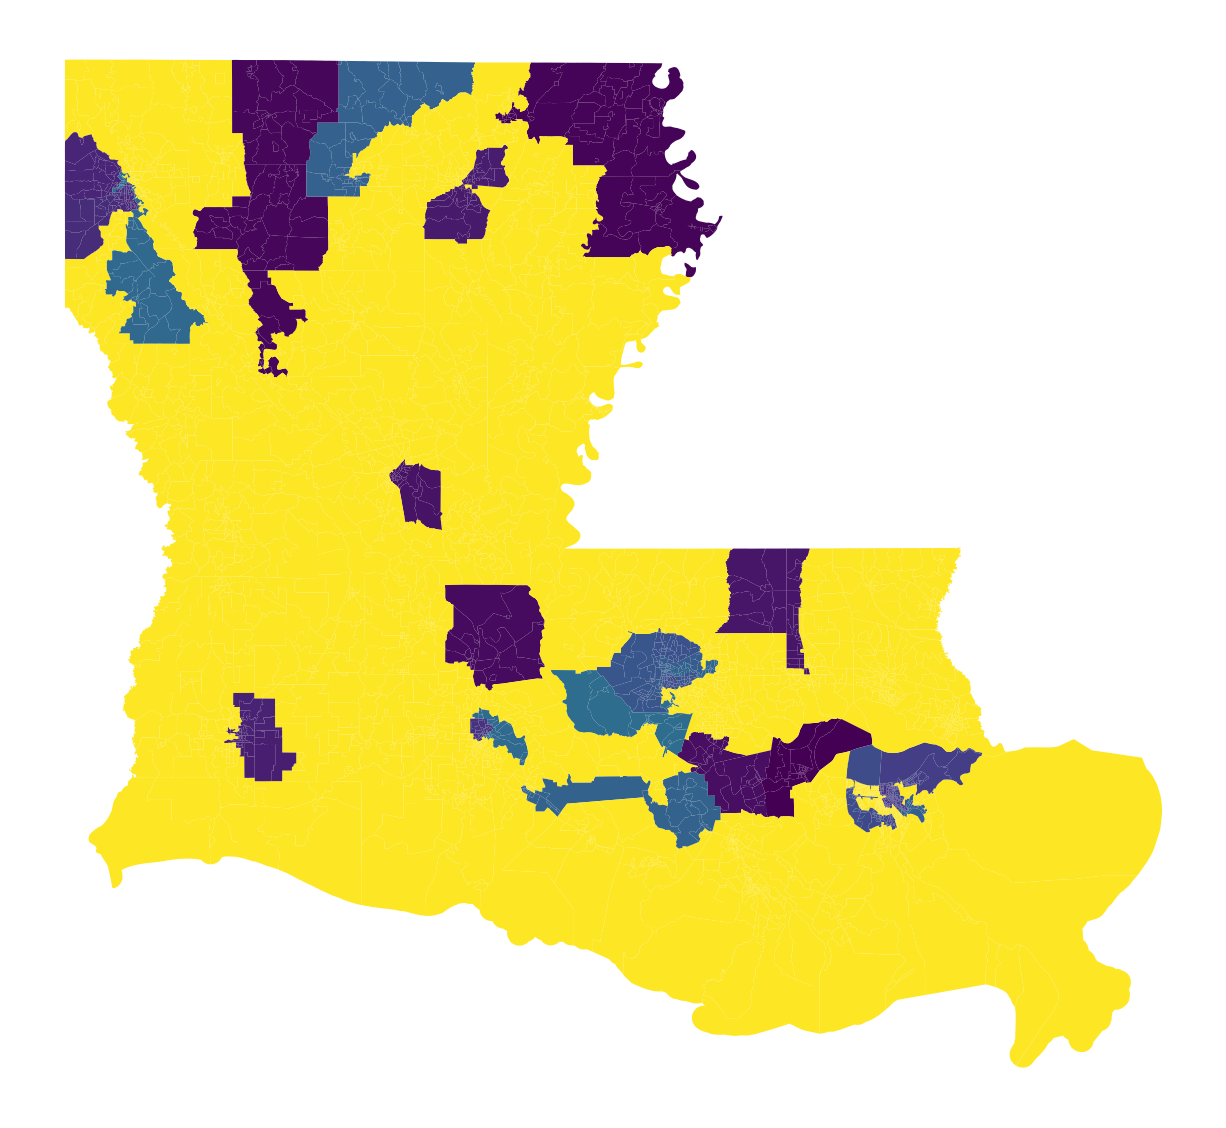

In [5]:
labeling = { i : G._k for i in G.nodes }
for j in range(len(gingles_districts)):
    for i in gingles_districts[j]:
        labeling[i] = j

G._state = state
G._level = level

from export import export_to_csv
export_to_csv(G, labeling, csv_filename="LA_SH_carve.csv")

from export import export_to_png
export_to_png(G, labeling, png_filename="LA_SH_carve.png")

from coarsen import subgraph
nodes = [ i for j in range(len(gingles_districts)) for i in gingles_districts[j] ]
GS = subgraph(G, nodes)

from metrics import average_polsby_popper
print(average_polsby_popper(GS, gingles_districts))

Using one split county, attempting to bipartition cluster into sizes: 33 34
Using one split county, attempting to bipartition cluster into sizes: 17 17
Using one split county, attempting to bipartition cluster into sizes: 8 9
Using one split county, attempting to bipartition cluster into sizes: 4 5
Using one split county, attempting to bipartition cluster into sizes: 2 3
Using one split county, attempting to bipartition cluster into sizes: 1 2
Using one split county, attempting to bipartition cluster into sizes: 1 1
Without limiting splits, attempting to bipartition cluster
Using one split county, attempting to bipartition cluster into sizes: 1 1
Using one split county, attempting to bipartition cluster into sizes: 2 2
Using one split county, attempting to bipartition cluster into sizes: 1 1
Using one split county, attempting to bipartition cluster into sizes: 1 1
Using one split county, attempting to bipartition cluster into sizes: 4 4
Using one split county, attempting to bipartition

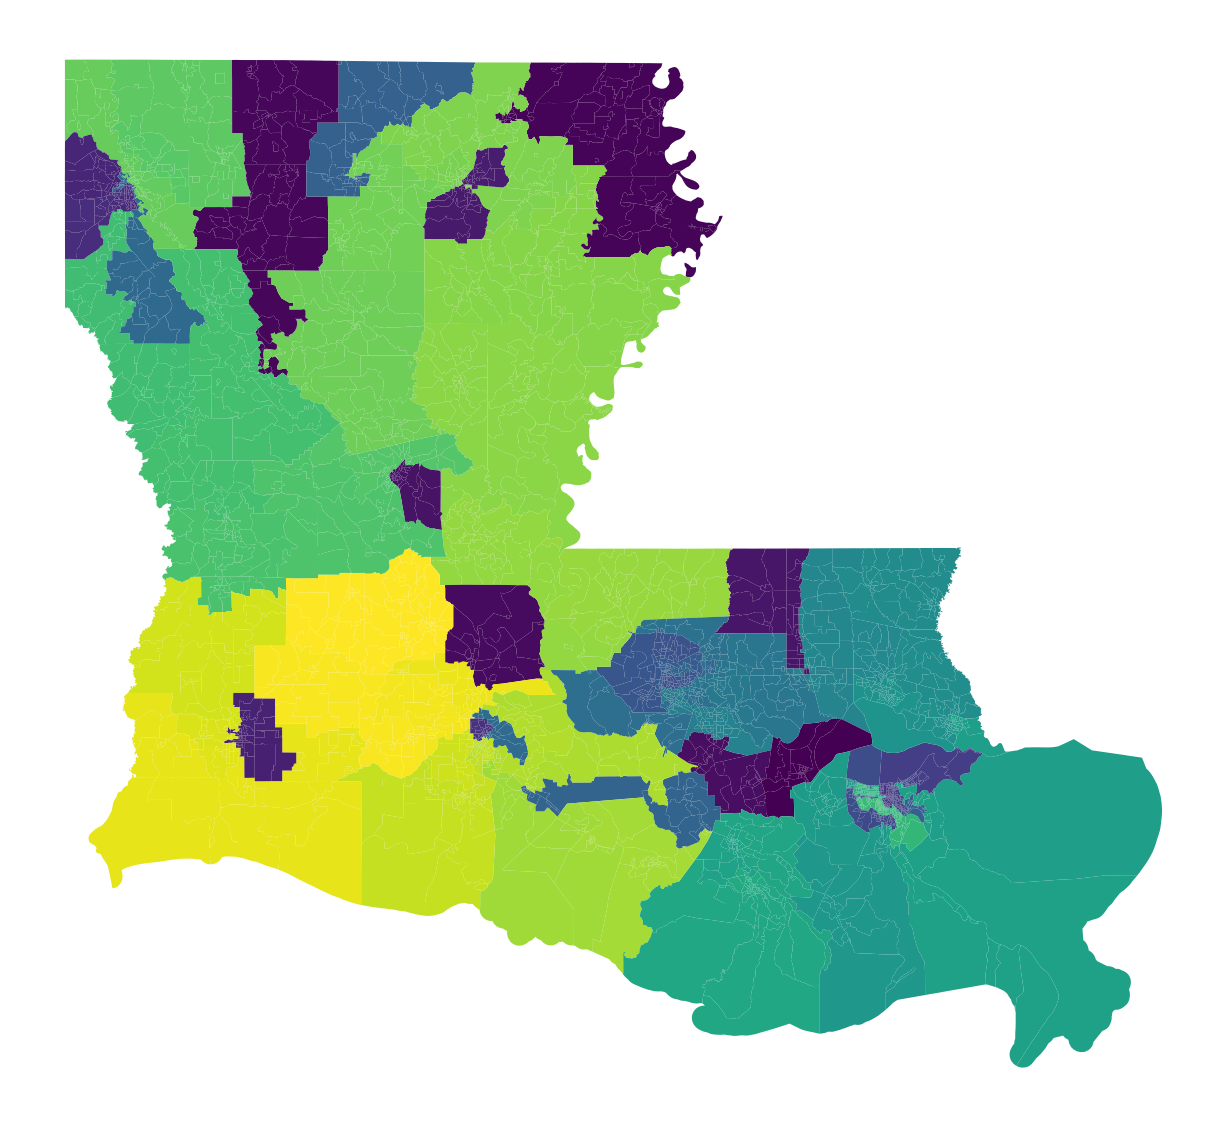

In [6]:
# Phase 2: complete the districting plan
from complete import recursive_bipartition_heuristic
complete_plan = recursive_bipartition_heuristic(G, gingles_districts=gingles_districts)
print(f"We now have a total of {len(complete_plan)} districts.")

from metrics import report_metrics 
report_metrics(G, complete_plan, minority=minority)
labeling = { i : j for j in range(len(complete_plan)) for i in complete_plan[j] }
export_to_png(G, labeling, png_filename="LA_SH_complete.png")
export_to_csv(G, labeling, csv_filename="LA_SH_complete.csv")

Applying MIP-based local search to improve the MIP warm start (hop parameter: 1)...
iter 		 obj 		 time
1 	 3.43897969 	 600.67
2 	 3.34856396 	 600.48
3 	 3.31566810 	 600.56
4 	 3.31198895 	 600.69
5 	 3.29864617 	 600.56
6 	 3.29864608 	 600.55
7 	 3.29018132 	 600.49
8 	 3.28984733 	 600.56
9 	 3.28648433 	 600.50
10 	 3.28648131 	 600.49
-> 38 majority-Black districts
-> 39 counties split a total of 113 times
-> average Polsby-Popper score of 0.3622
Exporting to png...
Exporting to csv...


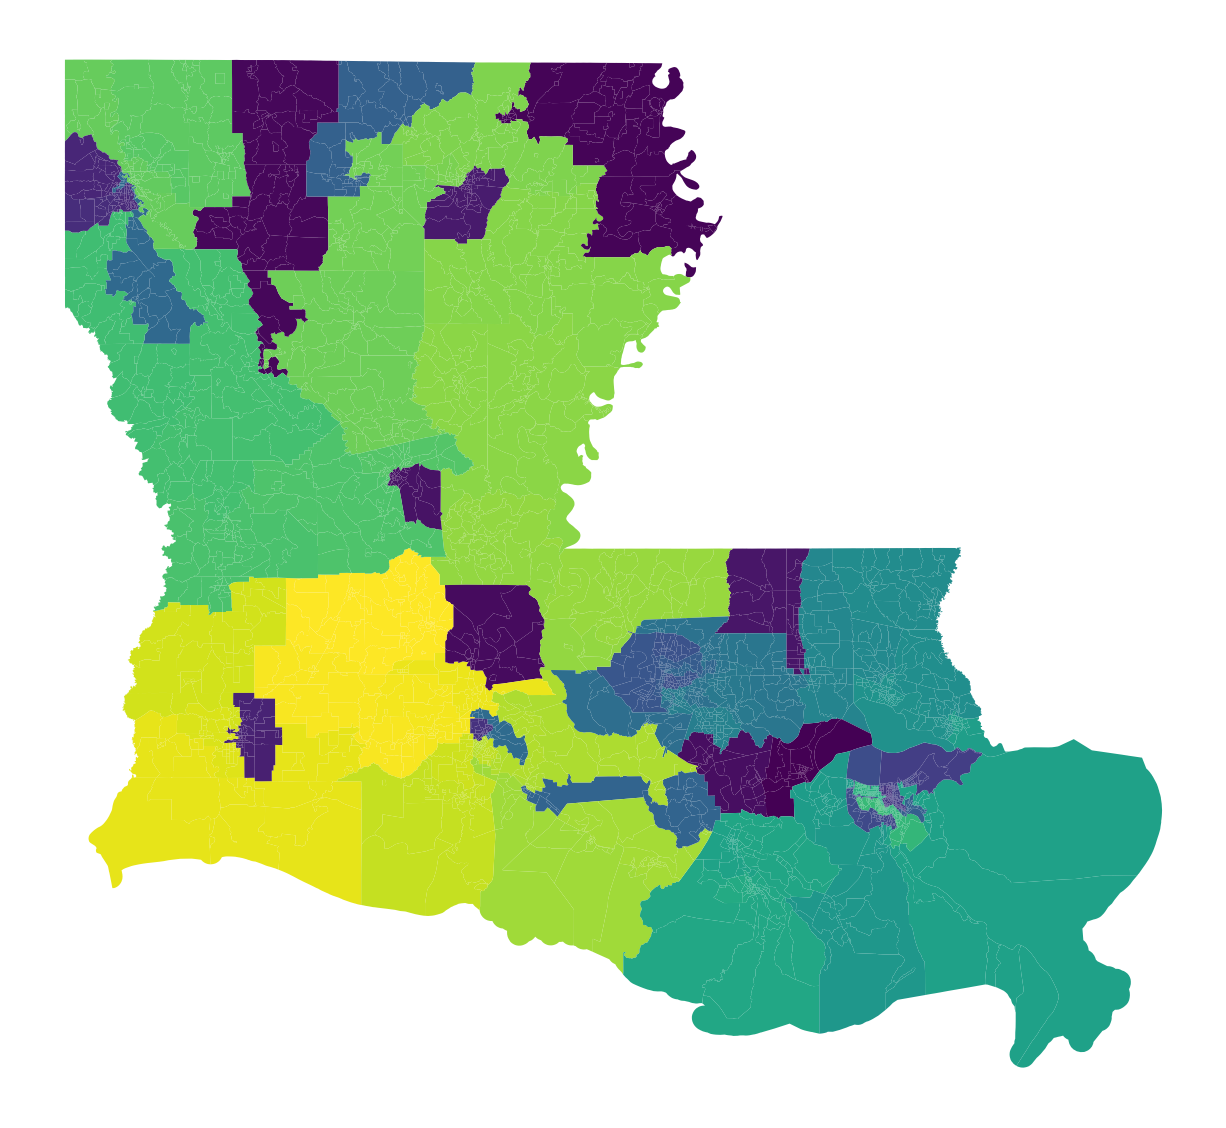

In [7]:
# Phase 3: cleanup the plan, making it more compact
from cleanup import mip_local_search
cleaned_plan = mip_local_search(G, complete_plan, minority=minority)
report_metrics(G, cleaned_plan, minority)

labeling = { i : j for j in range(len(cleaned_plan)) for i in cleaned_plan[j] }
export_to_png(G, labeling, png_filename="LA_SH_cleaned.png")
export_to_csv(G, labeling, csv_filename="LA_SH_cleaned.csv")